# Pembuatan model multi-variabel (Part II)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])

import scipy.special as sc
import pandas as pd
import pymc3 as pm
import arviz as az
import corner

import theano
import theano.tensor as tt
from theano.compile.ops import as_op

# az.style.use("arviz-darkgrid")
# plt.style.use('ggplot')
# plt.rcParams['font.family'] = 'Serif'

---

## Model details (dari A. Richichi, 1989)

Intensitas cahaya bintang pada peristiwa Okultasi Bulan sebagai fungsi dari waktu pengamatan, $I(t)$, bisa dituliskan sebagai:

\begin{align}
I(t) &= \int^\infty_{-\infty} d\phi \int^{A/2}_{A/2} d\alpha \int^{\lambda_2}_{\lambda_1} d\lambda \int^{0}_{\Delta \tau} d\tau \cdot F(w) S(\phi) O(\alpha) \Lambda(\lambda) T(\tau) + \beta
\end{align}

dengan:
- $S(\phi)$: profil kecerlangan bintang
- $O(\alpha)$: total integrasi luas area teleskop
- $\Lambda(\lambda)$: respon panjang gelombang (detektor + teleskop + filter)
- $T(\tau)$: respon waktu detektor}
- $\beta$: *background level*
- $F(w) = A \times \frac{1}{2} \left[\left(C(w) + \frac{1}{2}\right)^2 + \left(S(w) + \frac{1}{2}\right)^2 \right]$ dengan 
    - $w = \sqrt{\frac{2}{\lambda d_\mathrm{moon}}} x$. Karena $x = d_\mathrm{moon} \tan \phi$, maka $w = \tan \phi \sqrt{\frac{2 d_\mathrm{moon}}{\lambda}}$
    - $C(w) = \int_0^w \cos \left( \frac{\pi}{2} t^2 \right) dt$
    - $S(w) = \int_0^w \sin \left( \frac{\pi}{2} t^2 \right) dt$

## Cari jarak Bulan saat pengamatan

Ephemeris diambil dari https://ssd.jpl.nasa.gov/ftp/eph/planets/ascii/

In [2]:
from astropy import units as u
from skyfield.api import load

In [3]:
# load timescale dan tampilkan waktu saat ini
ts = load.timescale()
# t = ts.now()

# custom waktu untuk yyyy, mm, dd, hh, mm, ss
t = ts.utc(2020, 7, 29, 17, 17, 58.7247828)

In [4]:
# Load the JPL ephemeris DE430 (covers 1549-2650) dan cari jarak Bumi-Bulan
# planets = load('de421.bsp')
planets = load('de430.bsp')
earth, moon = planets['earth'], planets['moon']

In [5]:
# posisi Bulan dari Bumi
astrometric = earth.at(t).observe(moon)
ra, dec, distance = astrometric.radec()

In [6]:
# tampilkan koordinat Bulan dan jarak Bulan dalam km
print(ra)
print(dec)
print(distance.km)

16h 15m 32.10s
-19deg 12' 50.2"
374348.01497938664


In [7]:
# note: Jarak Bulan diambil dari perhitungan sebelumnya
# ===============================================
x_data = np.linspace(-100, 100, 500)

λ_init = 5250 * u.Angstrom # satuan Å

# Jarak Bulan diambil dari perhitungan 'skyfield'
d_moon = distance.km * u.km # satuan km
λ_range = np.linspace(4000, 9000, len(x_data))

In [8]:
d_moon

<Quantity 374348.01497939 km>

In [9]:
def fresnel_func(x, λ, d, A):
    w = x*u.m * np.sqrt(2 / (λ * d))
    w = w.decompose()*1.*u.dimensionless_unscaled
    
    cc, ss = sc.fresnel(w.value)
    y = A*0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
#     y_new = np.convolve(y, λ_range
    return y

In [10]:
A_true = 1000.
σ_true = 75.

y_data = fresnel_func(x_data, λ_init, d_moon, A_true)
y_data = np.random.normal(y_data, scale=σ_true)

In [11]:
y_data.shape

(500,)

Text(0, 0.5, 'Intensity')

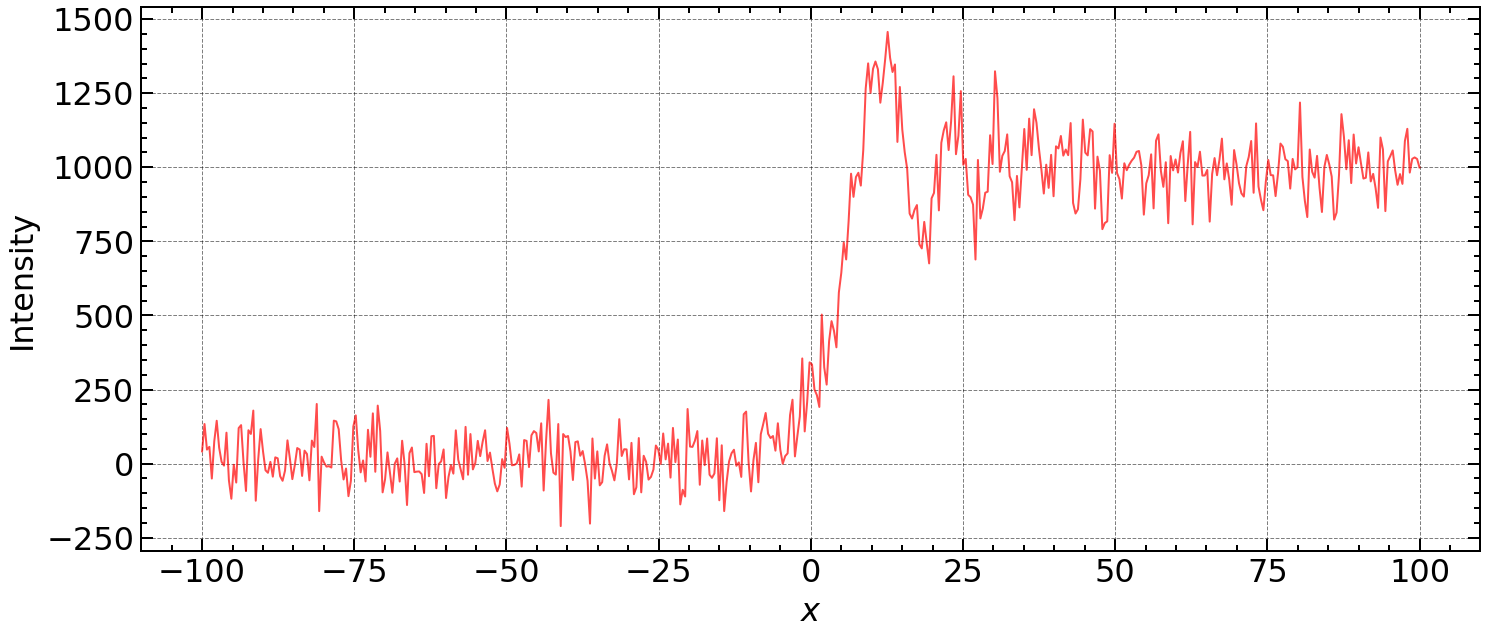

In [12]:
plt.figure(figsize = (12,5), facecolor='w')
# plt.scatter(x_data, y_data, c='r', s=5)
plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.7)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')

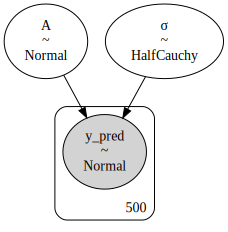

In [13]:
with pm.Model() as fresnel_model:
    A = pm.Normal('A', mu=950, sigma=1000)
    σ = pm.HalfCauchy('σ', beta=1.)
    
    μ = fresnel_func(x_data, λ_init, d_moon, A)
    y_pred = pm.Normal('y_pred', mu=μ, sd=σ, observed=y_data)
    
pm.model_to_graphviz(fresnel_model)

In [14]:
with fresnel_model:
    trace = pm.sample(2000, tune=2000, return_inferencedata=True, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, A]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [15]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,992.297,5.013,982.967,1001.427,0.089,0.063,3190.0,2581.0,1.0
σ,79.063,2.501,74.437,83.781,0.044,0.031,3239.0,3168.0,1.0


In [16]:
chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=fresnel_model)

In [17]:
crit_l = np.percentile(y_pred_g['y_pred'], 2.5, axis=0)  # 2.5% persentil 
crit_u = np.percentile(y_pred_g['y_pred'], 97.5, axis=0)  # 97.5% persentil
mean_spp = np.mean(y_pred_g['y_pred'], axis=0) # Median

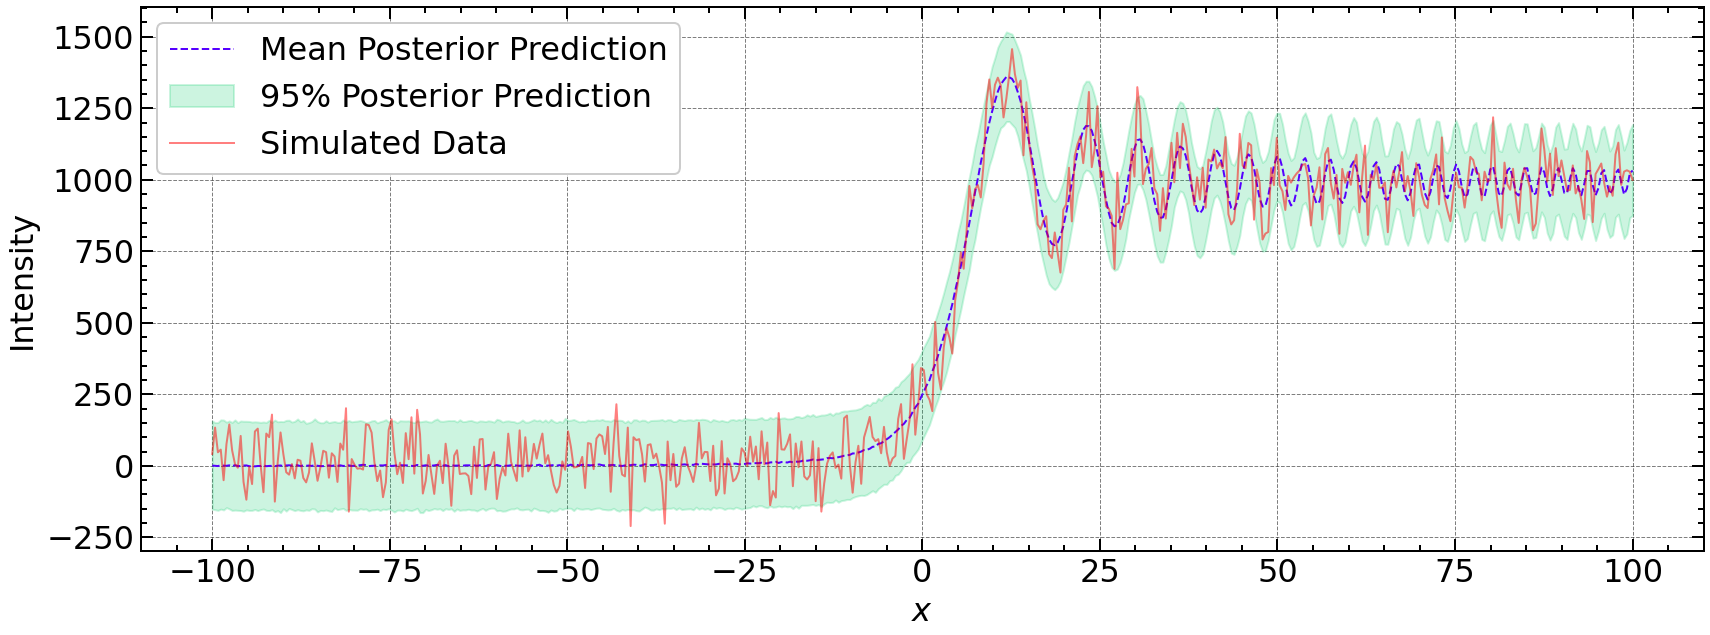

In [18]:
# import seaborn as sns

# with sns.plotting_context('talk', font_scale=1.):
#     _, ax = plt.subplots(figsize=(12,5))
plt.figure(figsize=(14,5))
plt.plot(x_data, mean_spp, linestyle='--', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
# plt.scatter(x_data, y_data, c='r', marker='.', s=3)
plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

<AxesSubplot:xlabel='A', ylabel='σ'>

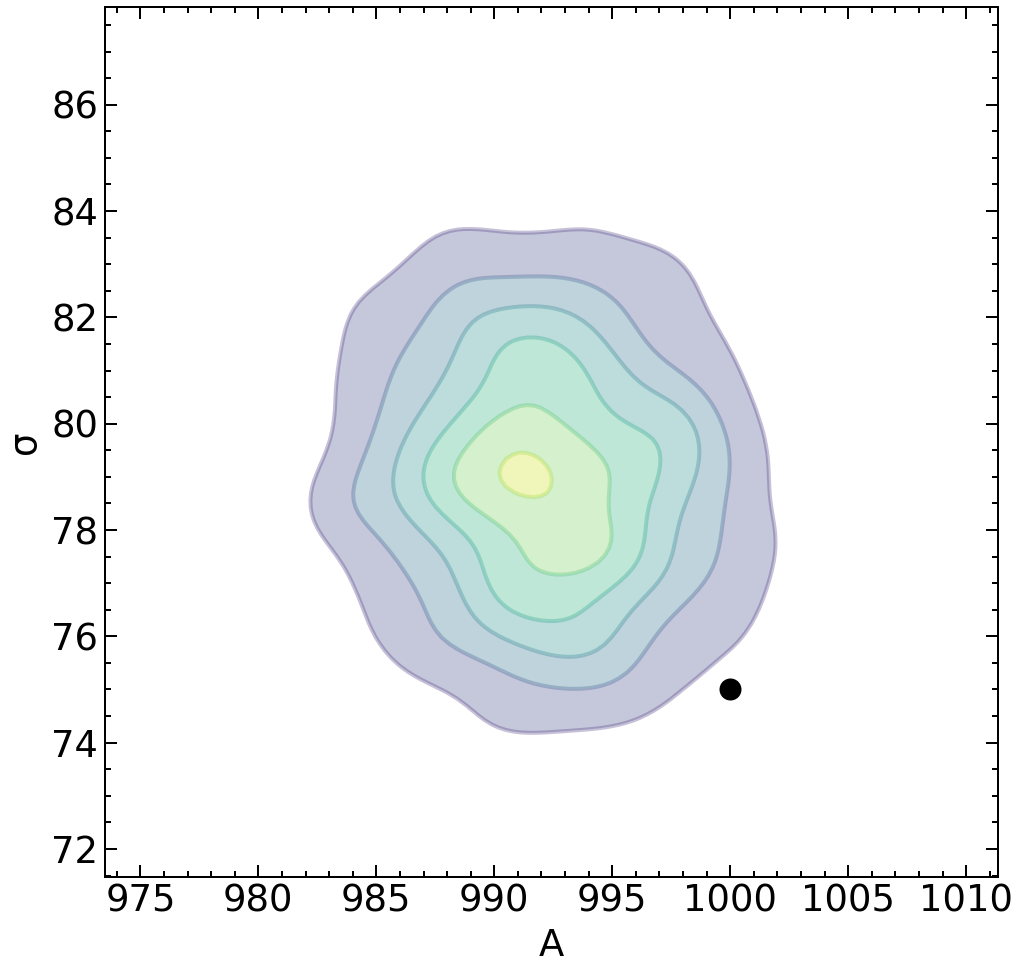

In [19]:
az.plot_pair(
    trace,
    var_names=['A', 'σ'],
    kind='kde',
    kde_kwargs={"contourf_kwargs":{"alpha": 0.3}, 
                "contour_kwargs": {"colors": None, "cmap": plt.cm.viridis, "alpha": 0.3}
               },
    figsize=(8,8),
    reference_values={"A":1000., "σ": 75},
    reference_values_kwargs={"marker": 'o', "ms": 10, "color": "k"},
)

In [20]:
y_data.shape

(500,)

## Model dengan memperhitungkan efek polikromatik

In [21]:
import astropy.units as u

In [49]:
# buat x-axis data. σ_true, dan A_true lagi supaya tidak bercampur
x_data2 = np.linspace(-100, 100, 500)

A_true2 = 1000.
σ_true2 = 2e3

# Rentang λ yang diperhitungkan dari 5500 s.d. 9000 Å, dengan selisih 100 Å dan bobot dianggap sama
bandwidth = np.arange(550, 900, 10) * u.nm

# Jarak Bulan dari teleskop, ambil nilai d_moon sebelumnya (sesuai waktu pengamatan)
d_moon2 = d_moon


In [50]:
# Model polikromatik
def fresnel_polikromatik(x, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = x * u.m * np.sqrt(2 / (bandwidth[i] * d))
        fre_num = w.decompose() * 1. * u.dimensionless_unscaled
        cc, ss = sc.fresnel(fre_num.value)
        # y = 0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y0 += y
    return y0

# def trans_curve(λ1, λ2):
#     return lambda x: 

In [51]:
y_data2 = fresnel_polikromatik(x_data2, d_moon2, A_true2)
y_data2 = np.random.normal(y_data2, scale=σ_true2)

Text(0, 0.5, 'Intensity')

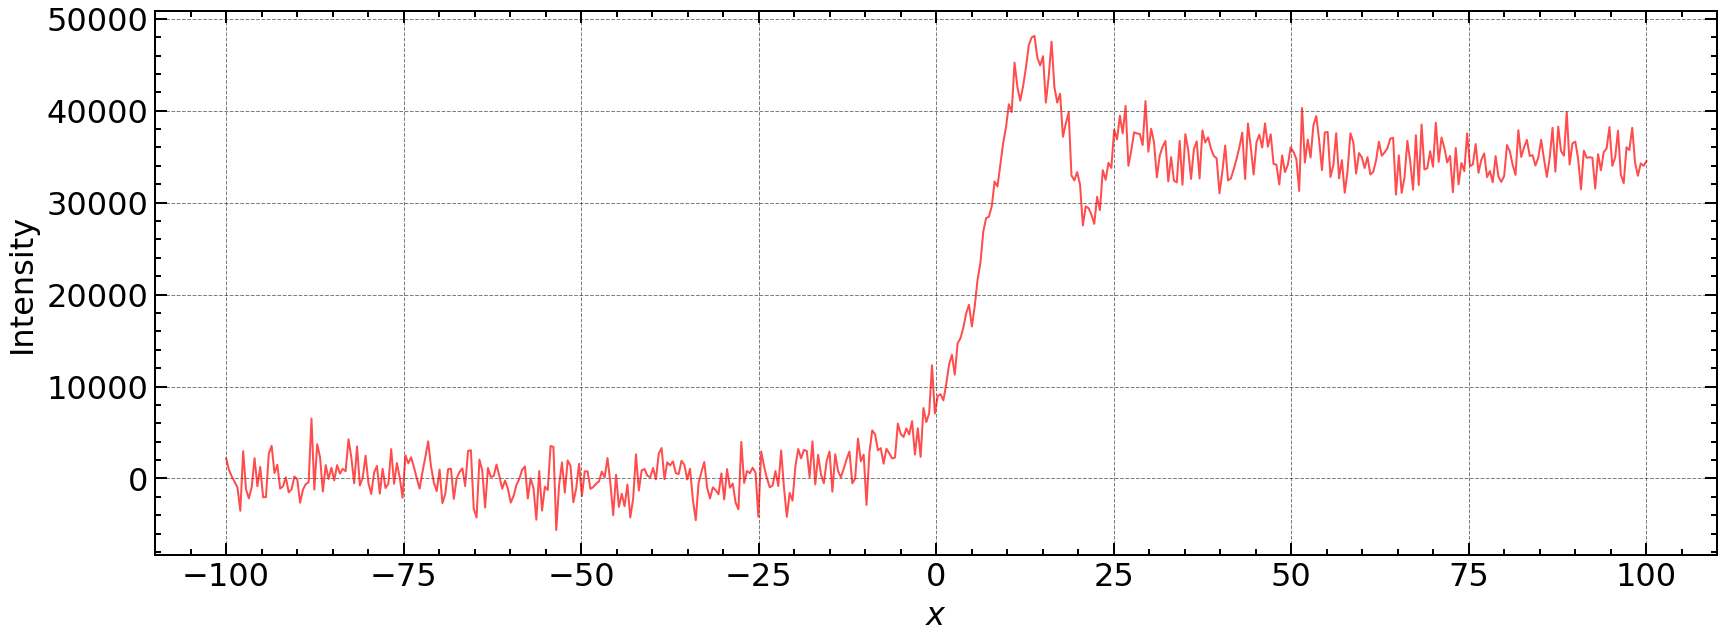

In [52]:
plt.figure(figsize = (14,5), facecolor='w')
# plt.scatter(x_data2, y_data2, c='r', s=5)
plt.plot(x_data2, y_data2, 'r-', lw=1, alpha=0.7)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')

Text(0, 0.5, 'Intensity')

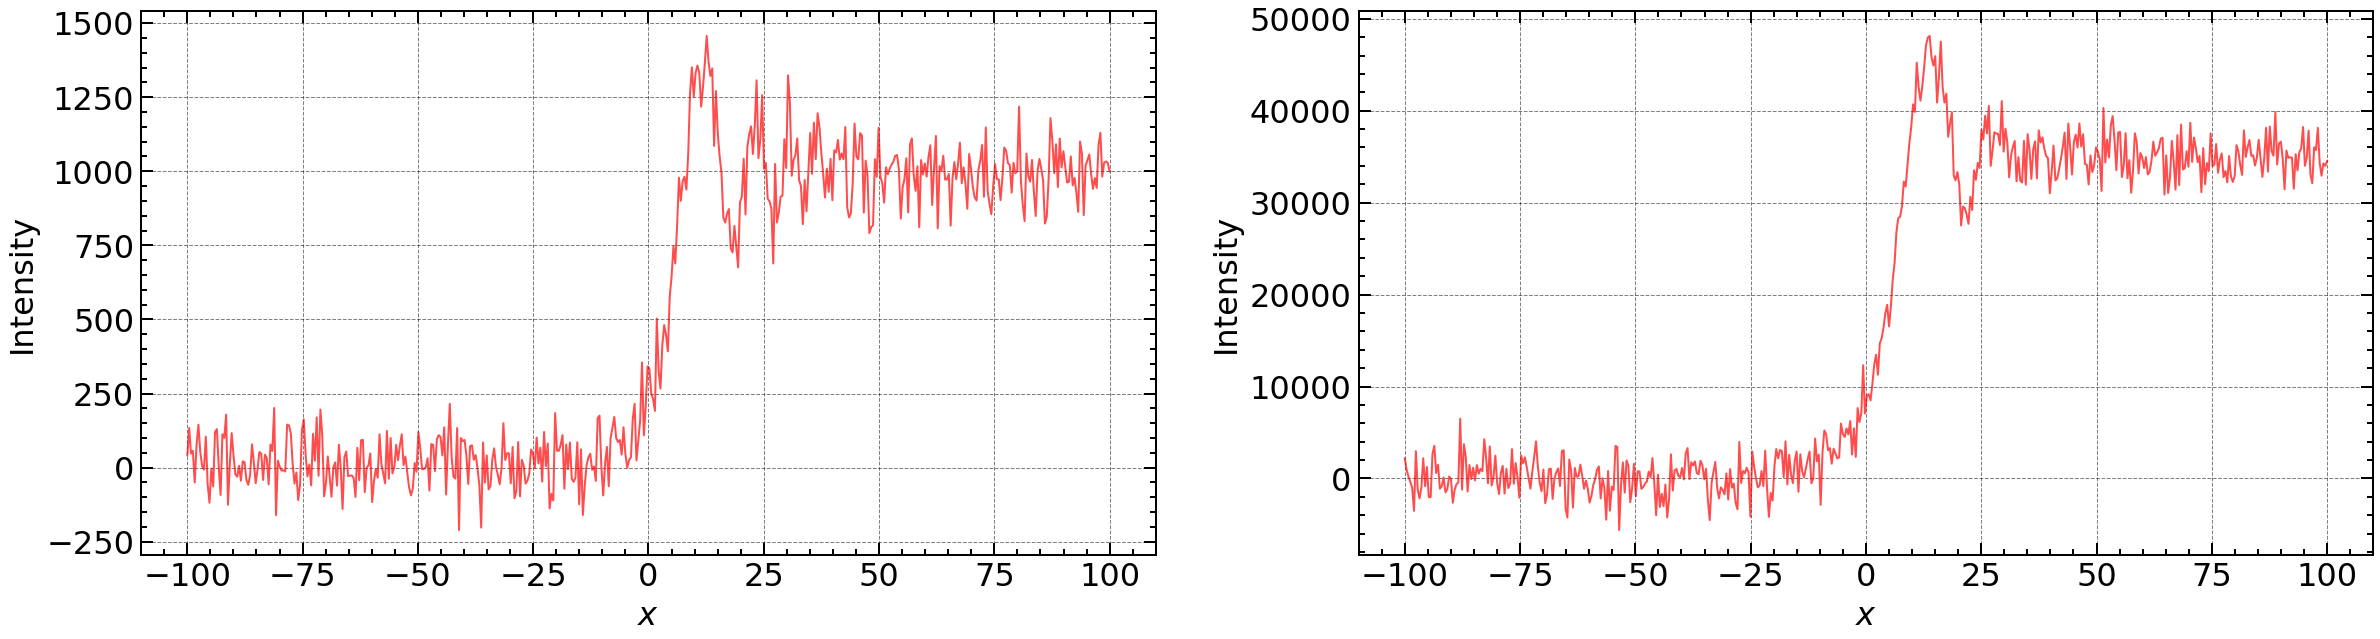

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

ax = axes[0]
ax.plot(x_data, y_data, 'r-', lw=1, alpha=0.7)
ax.set_xlabel('$x$')
ax.set_ylabel('Intensity')

ax = axes[1]
ax.plot(x_data2, y_data2, 'r-', lw=1, alpha=0.7)
ax.set_xlabel('$x$')
ax.set_ylabel('Intensity')

## Model Polikromatik dalam `PyMC3`

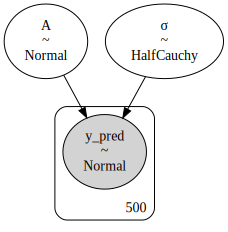

In [54]:
with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=950, sigma=1000)
    σ = pm.HalfCauchy('σ', beta=5.)
    
    μ = fresnel_polikromatik(x_data2, d_moon2, A)
    y_pred = pm.Normal('y_pred', mu=μ, sd=σ, observed=y_data2)
    
pm.model_to_graphviz(model_polikromatik)

In [55]:
with model_polikromatik:
    trace = pm.sample(10_000, tune=2500, return_inferencedata=True, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, A]


Sampling 2 chains for 2_500 tune and 10_000 draw iterations (5_000 + 20_000 draws total) took 112 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

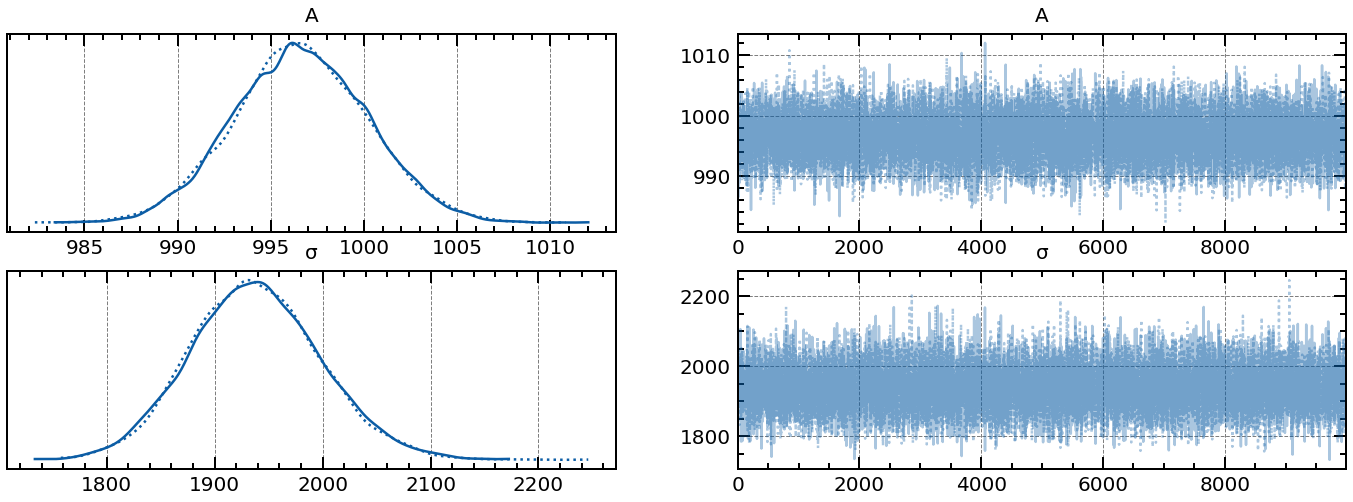

In [56]:
az.plot_trace(trace)

In [57]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,996.616,3.574,989.790,1003.301,0.030,0.021,14663.0,13564.0,1.0
σ,1937.848,60.363,1826.887,2054.567,0.502,0.355,14397.0,13487.0,1.0


In [58]:
chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_polikromatik)

In [59]:
crit_l = np.percentile(y_pred_g['y_pred'], 2.5, axis=0)  # 2.5% persentil 
crit_u = np.percentile(y_pred_g['y_pred'], 97.5, axis=0)  # 97.5% persentil
mean_spp = np.mean(y_pred_g['y_pred'], axis=0) # Median

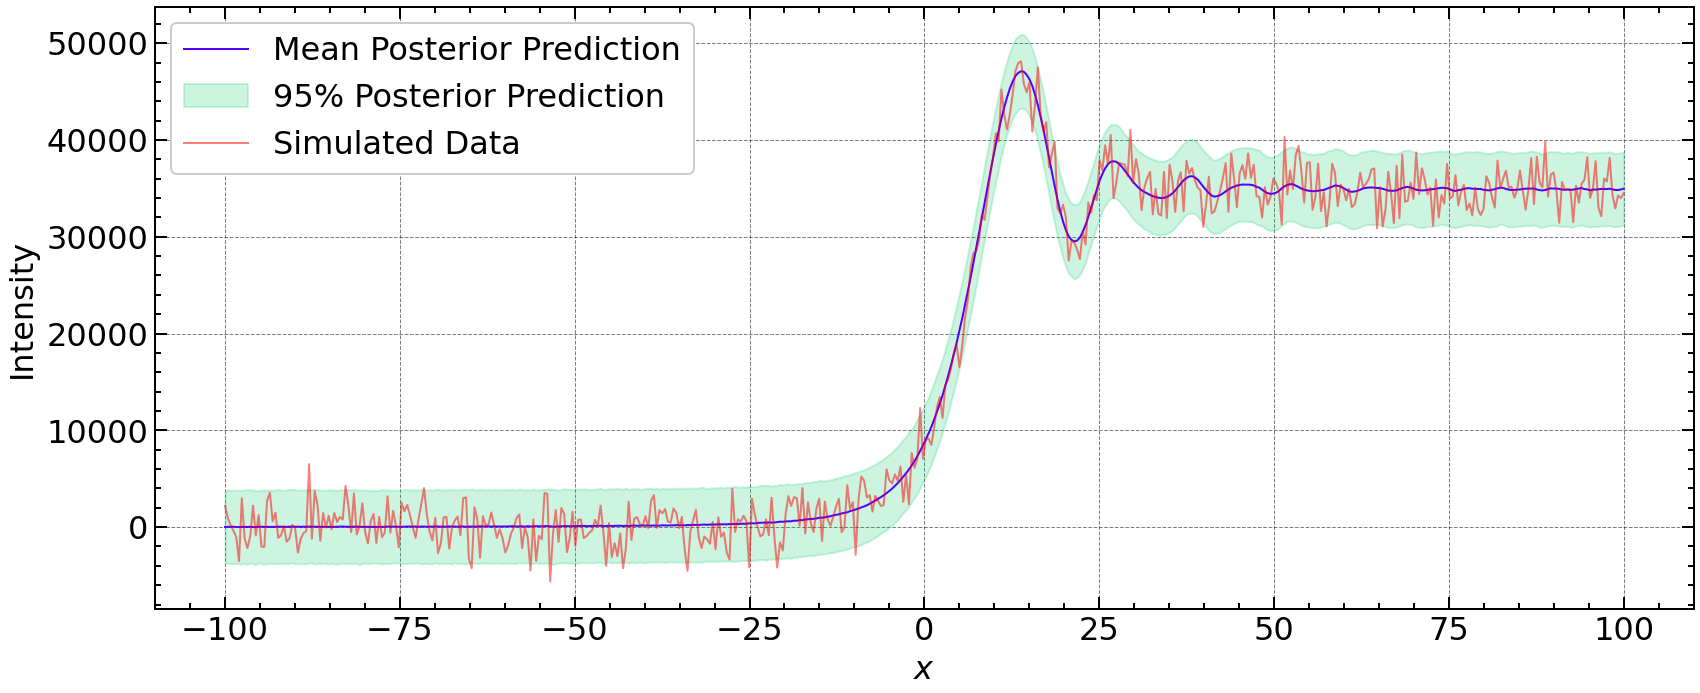

In [60]:
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data2, crit_l, crit_u, alpha=0.2, color="#00cc66")
# plt.scatter(x_data, y_data, c='r', marker='.', s=3)
plt.plot(x_data2, y_data2, 'r-', lw=1, alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')

<AxesSubplot:xlabel='A', ylabel='σ'>

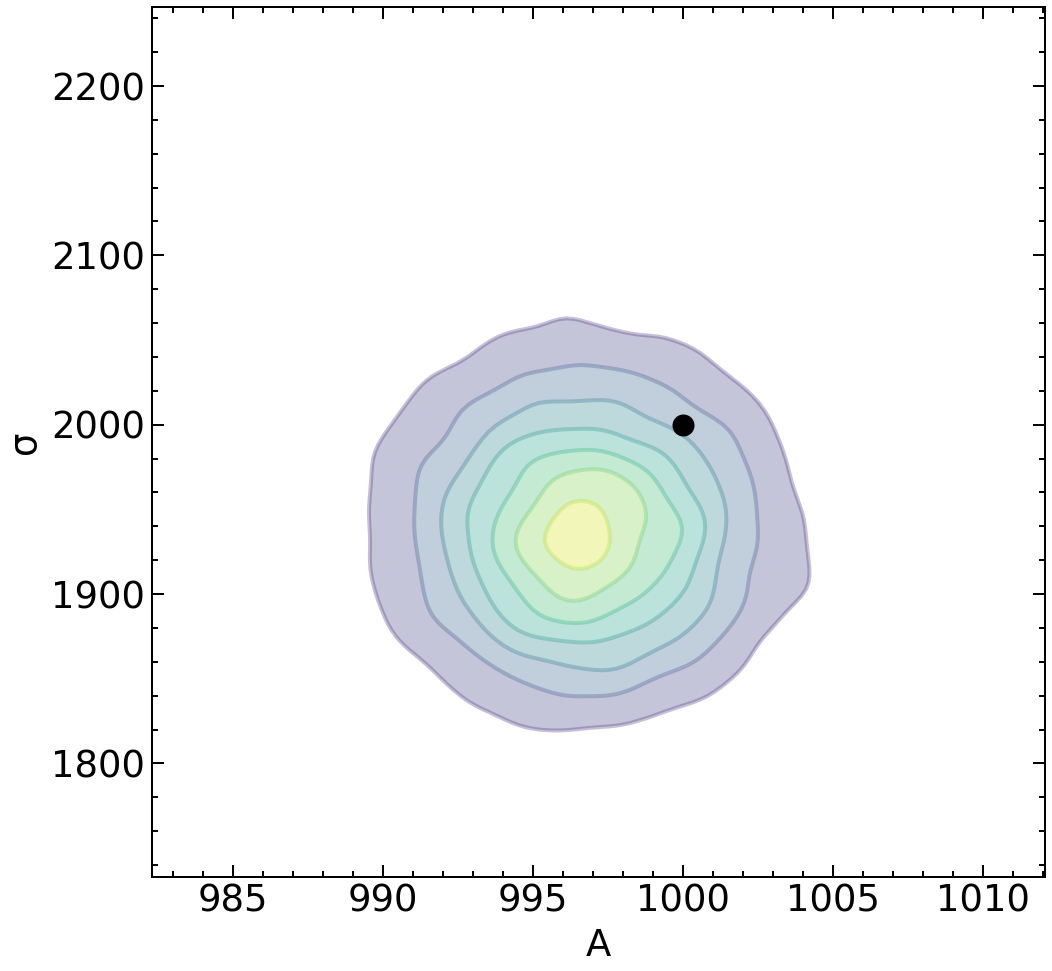

In [62]:
az.plot_pair(
    trace,
    var_names=['A', 'σ'],
    kind='kde',
    kde_kwargs={"contourf_kwargs":{"alpha": 0.3}, 
                "contour_kwargs": {"colors": None, "cmap": plt.cm.viridis, "alpha": 0.3}
               },
    figsize=(8,8),
    reference_values={"A":1000., "σ": 2000},
    reference_values_kwargs={"marker": 'o', "ms": 10, "color": "k"},
)

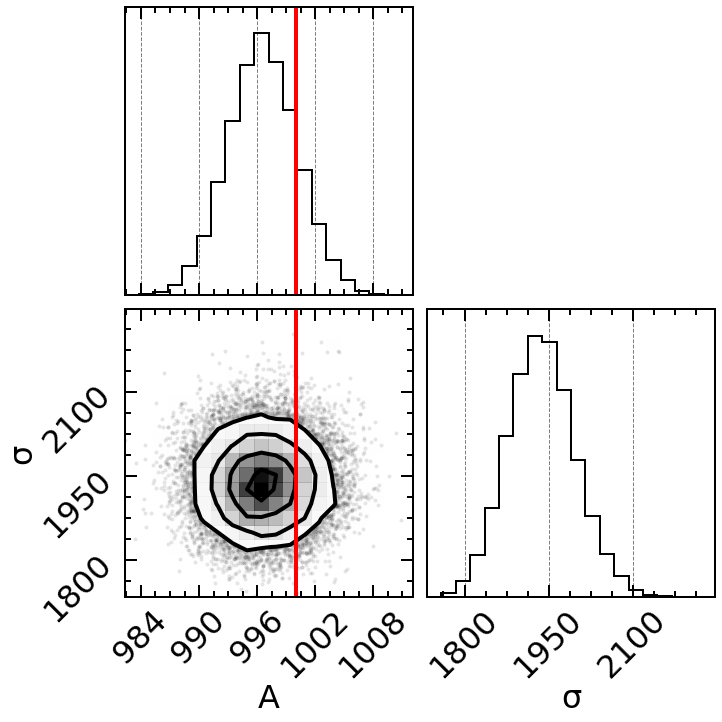

In [63]:
figure = corner.corner(trace, truths=[A_true, σ_true], truth_color='red', divergences=True)

## Kurva transmisi filter

Plot kurva transmisi filter untuk melihat bentuk umumnya (ambil kasus filter V). Filter diambil dari website https://old.aip.de/en/research/facilities/stella/instruments/data/johnson-ubvri-filter-curves/. 

In [ ]:
df = pd.read_csv('Bessel_V-1.txt', delimiter='\t', header=None)
df.head()

Ambil kolom yang tidak mengandung `NaN`

In [ ]:
data = df[[0, 2]]
data.columns = ['wavelength','percentage']

In [ ]:
data = data.dropna(axis=0)

In [ ]:
data['percentage']

Lakukan interpolasi terhadap data. Pastikan format data sudah benar (dalam hal ini`float`)

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
data_clean = data.dropna(axis=1)

In [ ]:
data_clean

In [ ]:
data['wavelength'] = data_clean['wavelength'].astype('float')
data['transmissivity'] = data_clean['percentage']/100.
data.head()

In [ ]:
x = data['wavelength']
y = data['transmissivity']
plt.plot(x, y, 'g')

In [ ]:
f = interp1d(x, y, kind='cubic')

In [ ]:
x_dense = np.linspace(400, 800, 500)
y_dense = f(x_dense)

In [ ]:
plt.plot(x_dense, y_dense, 'g', label='V band')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmissivity [%]')
plt.legend()

In [ ]:
f2 = np.sin(x_data)

In [ ]:
plt.plot(x_data, y_data)

In [ ]:
f3 = np.convolve(y_data, y_dense, 'same')
# f3 = y_data * y_dense

In [ ]:
plt.plot(x_data, f3)